#Ant Colony Optimization of Shortest Path and Traveling Salesman
# Harrison Naftelberg and Morgan McCarty
Notes

1. Shortest path was done in an attempt to use the least number of existing libraries possible to view more specific implementation details relating towards graphs. TSP was done with an existing graph implementation and ACO was built on top of that.

#Shortest Path

##Imports

In [ ]:
import numpy
import random

##Global Constants



In [ ]:
TRAIL_LAID = 10
PERSISTENCE = 0.95
ITERATIONS = 2000
ANT_MULTIPLIER = 1.0

##Node, Ant, Graph Classes

###Implementation details

####Nodes
Nodes are represented as an object which has a reference ID and a list of connections. Each element in the list of connections is a tuple which has a Integer and a Float. The Integer is either 1 or 0 corresponding to "does connect" and "does not connect." The Float value is the phermone value (later on the phermone is defaulted to 1 for connecting and 0 for non-connecting).

####Ants
Ants are the main component for solving the problem. They have internal values corresponding to the original point they began at, the goal point, the path they have taken (both as a set and a list -> the set to ensure that no node is taken twice, and the list to record the path taken), whether or not the ant is dead (locked out of any possible future paths or has already laid phermone), and the amount of trail to lay over an entire path.

####The Graph
The Graph is the problem to which the Ants find the solution. The code for the ACO is here as the Ants live within this space. The graph is essentially just a list of nodes.


In [ ]:
class Node():
  """ Class representing a Node in the Graph the ants will solve
  """

  def __init__(self, id: int, connections: list):
    """ Create a graph where:
          - id is an integer representing the ID of the node
          - connections is a list of tuples ((1 or 0), phermone: Float)
    """
    self.id = id
    self.connections = connections

  def __repr__(self):
    """ Returns the String value of the Node
          this is the id of the node followed by a list of the connections (ID values)
    """
    return str(self.id) + " - " + str(self.connections)

  def copy_connections(self):
    """ Creates and returns shallow copy of the connections list
    """
    copy = []
    for i in self.connections:
        copy.append((i))
    return copy

  def update_persistence(self, persistence):
    """ Updates the phermones of all connections within the graph by the persistence value
    """
    for i in range(len(self.connections)):
      x, y = self.connections[i]
      if y != None:
        y *= persistence
      self.connections[i] = (x, y)

  def update_phermone(self, id: int, phermone: float):
    """ Update the phermone on a specific edge
    """
    x, y = self.connections[id]
    y += phermone
    self.connections[id] = (x, y)

class Ant():
  """ Class representing an Ant (which will solve the graph collectively)
  """

  def __init__(self, origin: Node, goal: Node, trail_laid = TRAIL_LAID):
    """ Creates an Ant where:
          - origin is the Node at which the Ant started
          - goal is the Node to which the Ant wishes to travel
          - trail_laid is the total amount of trail to lay on the resulting path [Default = TRAIL_LAID]
        self.path is the list of the nodes which the Ant has taken up to and including the current node it is at
        self.current_node is the Node at which the Ant is located
        self.nodes_seen is the set of all nodes which the Ant has traveled to
        self.dead is the current state of the Ant, if the Ant attempts to travel and cannot travel to any legal nodes it is considered "dead" and will
          not attempt to travel any further until the generation is reset
    """
    self.current_node = origin
    self.origin = origin
    self.goal = goal
    self.nodes_seen = set()
    self.nodes_seen.add(origin)
    self.path = [origin]
    self.dead = False
    self.trail_laid = trail_laid

  def __repr__(self):
    """ Returns the String representation of the Ant
          This is the length of the current path taken followed by the ID of the current node and, if the Ant is dead, that is noted at the end
    """
    return f"{len(self.path)}-[{self.current_node.id}]" + ("DEAD" if self.dead else "")

  def get_phermone(self):
    """ Returns the phermone value (Float) generated by this Ants path
          This is equal to the TRAIL_LAID constant divided by the length of the path the Ant has taken
    """
    return self.trail_laid / len(self.path)

  def move(self, node: Node):
    """ Attempts to move the Ant to the given Node - note this does not ensure that the Node is adjacent to the other node, that is assumed to be known already
          (i.e. don't pass in a non-legal Node)

        If the move is made successfully Returns True, otherwise Returns False

        A move is successful if:
          - the Node is not None (this means we would want to travel nowhere so we kill the Ant as well)
          - the Node is not within the set of nodes visited so far
          - the Ant is not dead (if the Ant is dead it can't move!)

        When a successful move is made the Ant will update it current node, add the node to the set of nodes seen, and appends the node to its path of nodes
    """
    if node in self.nodes_seen:
      return False
    if node == None:
      self.dead = True
      return False
    if self.dead:
      return False
    self.nodes_seen.add(node)
    self.current_node = node
    self.path.append(node)
    if self.path_contains(self.origin.id) and self.path_contains(self.goal.id):
      self.dead = True
    return True

  def path_contains(self, id: int):
    """ Determines whether the Ant has traveled to the node asked
    """
    node_ids = [x.id for x in self.nodes_seen]
    set_ids = set()
    for i in self.nodes_seen:
      set_ids.add(i.id)
    return id in node_ids and id in set_ids

  def str_abridged_path(self):
    """ Returns the path as a string of IDs
    """
    ret = ""
    for i in self.path:
      ret = "-".join([ret, str(i.id)])
    return ret

class Graph():
  """ A class representing the Graph on which the Ants will travel
  """

  def __init__(self, nodes: list):
    """ Creates a Graph with:
          - nodes being a list of Nodes contained by the graph

        self.ants is a list of Ants that are currently searching the graph
    """
    self.nodes = nodes
    self.ants = []

  def __repr__(self):
    """ Returns the String representation of the Graph

        This is the nodes in the graph as a block connected by newlines
    """
    ret = ""
    for i in self.nodes:
      ret = "".join([ret, str(i), "\n"])
    return ret

  def make_ants(self, location: Node, goal: Node, trail_laid, ant_multiplier):
    """ Adds ants to the list of Ants at the specified location
    """
    self.ants = []
    for _ in range(int(len(self.nodes)*ant_multiplier)):
      self.ants.append(Ant(location, goal, trail_laid))

  def aco_path(self, to: int, fro: int, time: int, persistence=PERSISTENCE, trail_laid = TRAIL_LAID, ant_multiplier=ANT_MULTIPLIER):
    """ Applies the Ant Colony Optimization algorithm to the graph
    """
    self.make_ants(self.nodes[fro], self.nodes[to], trail_laid, ant_multiplier)
    best_path_so_far = []
    best_phermone = 0.0
    for _ in range(time): # O(time*n*n) -> O(n^2): not the best time complexity, but this is moreso about the extensibility to harder problems
      for i in self.nodes: # O(n^2)
        i.update_persistence(persistence) # O(n)
      for ant in self.ants: # O(n*)
        if ant.dead:
          continue
        sorted_connections = ant.current_node.copy_connections()
        # sort the edges by the phermone levels
        sorted_connections.sort(key=lambda x:x[1])

        # set to make sure that we don't attempt to go to the same node twice
        indices_hit = set()

        for sorted_index in range(len(sorted_connections)): # O(n)
          successful_move = False
          connect, _ = sorted_connections[sorted_index]

          # convert indices for the sorted edges to their corresponding non-sorted indices
          real_indices = [i for i, tupl in enumerate(ant.current_node.connections) if tupl == sorted_connections[sorted_index]]

          if connect == 1:
            # as all of these edges must have the same weight we will just choose one randomly and then do the next, etc.
            random.shuffle(real_indices)
            for i in real_indices: # effectively O(1) as we will only go to every index once for the previous loop
              indices_hit.add(i)
              if ant.move(self.nodes[i]):
                successful_move = True
                break
          else:
            # all of these don't connect so we can just add the indices so we don't use them again later
            for i in real_indices:
              indices_hit.add(i)

          if successful_move:
            # after every move one connection will be added, so if we now have the "to" and the "fro" we must have a path that goes from "fro" to "to"
            if ant.path_contains(to) and ant.path_contains(fro):
              # we want the best path so we will look at the score for the previous best path and then replace it if this one is better
              path_found = ant.path
              new_phermone = ant.get_phermone()
              if new_phermone > best_phermone:
                best_phermone = new_phermone
                best_path_so_far = path_found
              for i in range(1, len(ant.path)-1): # O(n)
                # update the phermones for the connections from this node
                self.nodes[i-1].update_phermone(i, new_phermone)
            break

    return best_path_so_far, best_phermone

##Convenience Function to run ACO

This is created to use the information create above to run ACO with different parameters and arguments.

In [ ]:
def ant_colony_optimization(node_origin: int, node_destination: int, node_count: int, iterations=ITERATIONS, persistence=PERSISTENCE, ant_multiplier=ANT_MULTIPLIER, trail_laid=TRAIL_LAID, seed=44100, print_graph=False):
  """ Runs the Ant Colony Optimization for Shortest Path on a new Graph

      Prints out the resulting path (as node IDs connected by arrows)

      Args:
        - node_origin: the Integer ID value of the Node to start the path from
        - node_destination: the Integer ID value of the Node to end the path at
        NOTE: node_origin cannot be the same value as node_destination
        - node_count: the non-negative, non-zero Integer value for the number of nodes in the graph
        - iterations: the Integer number of iterations to run ants over the graph [Default = ITERATIONS]
        - persistence: the Float persistence of the trails laid by the ants [Default = PERSISTENCE]
        - ant_multiplier: the Float value by which the number of ants compared to the number of nodes will be multiplied (i.e. #ants = floor(node_count * ant_multiplier)) [Default = ANT_MULTIPLIER]
        - trail_laid: the total Integer amount of phermone which one ant will lay upon the trail it finds [Default = TRAIL_LAID]
        - seed: the random seed to be used to create the graph either an Integer or the String "random" to designate a random seed [Default = 44100]
        - print_graph: a Boolean value which dictates whether or not the graphs will be printed [Default = False]
  """
  assert(node_count > 0)

  assert(node_origin != node_destination)

  # Set the seed
  if type(seed) == int:
    rng = numpy.random.default_rng(seed)
    random.seed(seed)
  else:
    assert(seed == 'random')
    rng = numpy.random.default_rng()

  # Create the graph (adj matrix)
  adjacency_matrix = rng.random((node_count, node_count))
  for i in range(len(adjacency_matrix)):
    for j in range(len(adjacency_matrix[i])):
      adjacency_matrix[i][j] = (round(adjacency_matrix[i][j], 0))
      if i == j:
        # we don't want the graph to have edges where both ends are on the same node
        adjacency_matrix[i][j] = 0
  for i in range(len(adjacency_matrix)):
    for j in range(len(adjacency_matrix[i])):
      if adjacency_matrix[i][j] == 1 and adjacency_matrix[j][i] != 1:
        # this ensures that the graph is not directed (paths go both ways)
        adjacency_matrix[j][i] = 1
  adjacency_matrix_int = adjacency_matrix.astype("int64")

  if print_graph:
    print("Adjacency Matrix:")
    print(adjacency_matrix_int)
    print()

  # Convert adjacency_matrix_int into Node objects
  nodes = []
  for i in range(len(adjacency_matrix_int)):
    connections = []
    for j in range(len(adjacency_matrix_int[i])):
      connections.append((adjacency_matrix_int[i][j], 1.0) if adjacency_matrix_int[i][j] == 1 else (adjacency_matrix_int[i][j], 0.0))
    nodes.append(Node(i, connections))
  graph = Graph(nodes)

  if print_graph:
    print("Graph:")
    print(graph)
    print()

  result = graph.aco_path(node_destination, node_origin, iterations, persistence, ant_multiplier)

  id_path = []

  path, _ = result

  for i in path:
    id_path.append(str(i.id))

  if path:
    print(f"Path from Node-{node_origin} to Node-{node_destination}:")
    print(("->".join(id_path)))
  else:
    print("Could not find a valid path! (Try running more iterations)")
  print()

Example runs with varied arguments and varied parameters

In [ ]:
ant_colony_optimization(2, 8, 18, print_graph=True)
ant_colony_optimization(1, 2, 10)
ant_colony_optimization(7, 22, 30, iterations=50, persistence=0.8, ant_multiplier=10.0, trail_laid=20, print_graph=True)

Adjacency Matrix:
[[0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1]
 [1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1]
 [0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0]
 [0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1]
 [1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0]
 [0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1]
 [0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1]
 [1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1]
 [0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1]
 [1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0]
 [0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1]
 [1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1]
 [0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0]
 [0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
 [1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0]
 [0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0]
 [0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0]]

Graph:
0 - [(0, 0.0), (1, 1.0), (1, 1.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (1, 1.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0)]
1 - [(1, 1.0), (0, 0.0), (1, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (

In [ ]:
# change in persistence does not have an effect on small graphs
%time ant_colony_optimization(0, 16, 20, persistence=0.1)
%time ant_colony_optimization(0, 16, 20, persistence=0.5)
%time ant_colony_optimization(0, 16, 20, persistence=0.8)
%time ant_colony_optimization(0, 16, 20, persistence=2.0)

Path from Node-0 to Node-16:
0->16

CPU times: user 1.13 s, sys: 1.43 ms, total: 1.13 s
Wall time: 1.14 s
Path from Node-0 to Node-16:
0->16

CPU times: user 1.12 s, sys: 108 µs, total: 1.12 s
Wall time: 1.13 s
Path from Node-0 to Node-16:
0->16

CPU times: user 1.08 s, sys: 797 µs, total: 1.08 s
Wall time: 1.08 s
Path from Node-0 to Node-16:
0->16

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.12 s


In [ ]:
# change in persistence had a large effect once it became larger in large graphs
%time ant_colony_optimization(0, 16, 100, persistence=0.1)
%time ant_colony_optimization(0, 16, 100, persistence=0.5)
%time ant_colony_optimization(0, 16, 100, persistence=0.8)
%time ant_colony_optimization(0, 16, 100, persistence=2.0)
%time ant_colony_optimization(0, 16, 100, persistence=4.0)

Path from Node-0 to Node-16:
0->88->16

CPU times: user 30.1 s, sys: 62.7 ms, total: 30.1 s
Wall time: 30.2 s


KeyboardInterrupt: ignored

In [ ]:
# change in trail_laid has zero effect (as expected because its porportional to the number of edges in the trail)
%time ant_colony_optimization(0, 12, 20, trail_laid=1000)
%time ant_colony_optimization(0, 12, 20, trail_laid=100)
%time ant_colony_optimization(0, 12, 20, trail_laid=10)
%time ant_colony_optimization(0, 12, 20, trail_laid=1)

Path from Node-0 to Node-12:
0->12

CPU times: user 225 ms, sys: 999 µs, total: 226 ms
Wall time: 226 ms
Path from Node-0 to Node-12:
0->12

CPU times: user 235 ms, sys: 0 ns, total: 235 ms
Wall time: 238 ms
Path from Node-0 to Node-12:
0->12

CPU times: user 238 ms, sys: 2 ms, total: 240 ms
Wall time: 242 ms
Path from Node-0 to Node-12:
0->12

CPU times: user 245 ms, sys: 0 ns, total: 245 ms
Wall time: 246 ms


In [ ]:
# change in ant_multiplier has zero effect on small graphs
%time ant_colony_optimization(0, 12, 20, ant_multiplier=100)
%time ant_colony_optimization(0, 12, 20, ant_multiplier=1)
%time ant_colony_optimization(0, 12, 20, ant_multiplier=0.5)
%time ant_colony_optimization(0, 12, 20, ant_multiplier=0.1)

Path from Node-0 to Node-12:
0->12

CPU times: user 222 ms, sys: 3.01 ms, total: 225 ms
Wall time: 225 ms
Path from Node-0 to Node-12:
0->12

CPU times: user 232 ms, sys: 4 µs, total: 232 ms
Wall time: 233 ms
Path from Node-0 to Node-12:
0->12

CPU times: user 224 ms, sys: 2 ms, total: 226 ms
Wall time: 227 ms
Path from Node-0 to Node-12:
0->12

CPU times: user 233 ms, sys: 2 ms, total: 235 ms
Wall time: 235 ms


In [ ]:
#no real change for large graph either
%time ant_colony_optimization(0, 12, 100, ant_multiplier=100)
%time ant_colony_optimization(0, 12, 100, ant_multiplier=1)
%time ant_colony_optimization(0, 12, 100, ant_multiplier=0.5)
%time ant_colony_optimization(0, 12, 100, ant_multiplier=0.1)

%time ant_colony_optimization(0, 16, 100, ant_multiplier=100)
%time ant_colony_optimization(0, 16, 100, ant_multiplier=1)
%time ant_colony_optimization(0, 16, 100, ant_multiplier=0.5)
%time ant_colony_optimization(0, 16, 100, ant_multiplier=0.1)

Path from Node-0 to Node-12:
0->12

CPU times: user 7.51 s, sys: 14 ms, total: 7.52 s
Wall time: 7.52 s
Path from Node-0 to Node-12:
0->12

CPU times: user 7.44 s, sys: 17 ms, total: 7.46 s
Wall time: 7.47 s
Path from Node-0 to Node-12:
0->12

CPU times: user 7.4 s, sys: 20 ms, total: 7.42 s
Wall time: 7.42 s
Path from Node-0 to Node-12:
0->12

CPU times: user 7.39 s, sys: 14 ms, total: 7.4 s
Wall time: 7.41 s
Path from Node-0 to Node-16:
0->88->16

CPU times: user 30.5 s, sys: 54 ms, total: 30.5 s
Wall time: 30.5 s
Path from Node-0 to Node-16:
0->88->16

CPU times: user 30.9 s, sys: 55 ms, total: 31 s
Wall time: 31 s
Path from Node-0 to Node-16:
0->88->16

CPU times: user 31.4 s, sys: 77 ms, total: 31.5 s
Wall time: 31.5 s
Path from Node-0 to Node-16:
0->88->16

CPU times: user 31 s, sys: 54 ms, total: 31 s
Wall time: 31 s


#Traveling Salesman

Below is code to generate a fully connected graph on which to run the ant cycle algorithm. Each edge is given a random 'visibility' or length between the Min and Max length constants (1-50 here)

Graph with 10 nodes and 45 edges
Visbilities:  {(0, 1): 40, (0, 2): 17, (0, 3): 33, (0, 4): 10, (0, 5): 39, (0, 6): 36, (0, 7): 20, (0, 8): 17, (0, 9): 44, (1, 2): 12, (1, 3): 46, (1, 4): 35, (1, 5): 28, (1, 6): 38, (1, 7): 1, (1, 8): 22, (1, 9): 5, (2, 3): 40, (2, 4): 23, (2, 5): 17, (2, 6): 50, (2, 7): 37, (2, 8): 39, (2, 9): 15, (3, 4): 33, (3, 5): 26, (3, 6): 17, (3, 7): 48, (3, 8): 44, (3, 9): 22, (4, 5): 6, (4, 6): 42, (4, 7): 50, (4, 8): 41, (4, 9): 48, (5, 6): 44, (5, 7): 26, (5, 8): 2, (5, 9): 50, (6, 7): 49, (6, 8): 44, (6, 9): 37, (7, 8): 10, (7, 9): 15, (8, 9): 23}


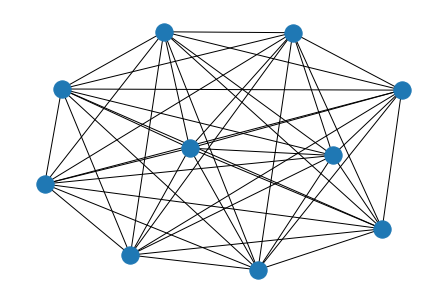

In [ ]:
import networkx as nx
import random
TRAIL_LAID = 10
PERSISTENCE = 0.5

SEED = 4100
MAX_LENGTH = 50
MIN_LENGTH = 1

random.seed(4100)

g = nx.generators.random_graphs.erdos_renyi_graph(10, 1, seed=SEED)


# generate edge visibilities (distances)
visibility = {}
for e in g.edges():
  visibility[e] = random.randint(MIN_LENGTH,MAX_LENGTH)

print(g)
print('Visbilities: ', visibility)

nx.draw(g)

Below is the code for running the ant colony optimization code. The Ant class is a simple object that only holds a list of nodes an ant has visited, the current node the ant is on, and an identifying number.

The ant cycle algorithm takes in a graph, number of ants to send out per cycle, a node to start on, a dictionary of visibilities, and our changable parameters including ALPHA (how important the trail is), BETA (how important visibility is), the maximum number of cycles to run through, and the starting trail constant for each edge.

The algorithm first initializes everything, including setting a variable for the shortest tour so far, time, number of cycles, and a trail intensity dictionary. The main function takes place in a loop that continues until the maximum number of cycles has been reaches OR until stagnation behavior is displayed. Ants are considered stagnating when all ants take the exact same route. We have yet to have this happen.

Within each cycle ants are sent out from the origin node. The next node to go to is selected by calculating transition probabilities based on visibility and trail intensity. Each ant moves to a new node and that node is stored in the nodes its visited so far. The ants continue until they have all visited each node. Ants then lay down trail, intensities are updated according to the length of the path each ant found, then all ants are reset and start again.

In [ ]:
ALPHA = 2 ### Relative Importance of Trail
BETA = 2 ### Relative Importance of Visibility
MAX_CYCLES = 10000
C = 3


class Ant(object):
  def __init__(self, current_node, num):
    self.tabu_list = [current_node]
    self.current_node = current_node
    self.num = num

  def __str__(self):
    return 'Ant ' + str(self.num)

def ant_cycle_algo(g, m, start_node, visibility, ALPHA=ALPHA, BETA=BETA, MAX_CYCLES=MAX_CYCLES, C=3):
  '''
  Parameters:
    g: graph
    m: number of ants
    start_node: start node
  '''
  # Initialize
  shortest_tour = None
  shortest_tour_len = None
  time = 0
  cycles = 0
  trail_intensity = {}
  trail_intensity[time] = {}
  for edge in g.edges:
    trail_intensity[time][edge] = C

  ants_per_node = {}
  ants_per_node[time] = {}
  for node in g.nodes:
    ants_per_node[time][node] = 0

  stagnating = False
  while cycles < MAX_CYCLES and not stagnating:
    # Set up ants and tabu lists
    ants = []
    for i in range(m):
      ant = Ant(start_node, i)
      ants.append(ant)
      ants_per_node[time][0] += 1

    # Calculate probabilities and move each ant
    tabu_index = 0
    while tabu_index < len(g.nodes) - 1:
      tabu_index += 1
      for ant in ants:

        # Caluclate Transition Probs
        transition_probs = {}
        i = ant.current_node

        for edge in g.edges:
          if (edge[0] == i or edge[1] == i) and (edge[1] not in ant.tabu_list or edge[0] not in ant.tabu_list):
            numerator = (trail_intensity[time][edge] ** ALPHA) * (visibility[edge] ** BETA)
            denom = 0
            for k in filter(lambda x: x not in ant.tabu_list, g.edges):
              denom += (trail_intensity[time][edge] ** ALPHA) * (visibility[edge] ** BETA)
            if denom == 0:
              transition_probs[edge] = 0
            else:
              transition_probs[edge] = numerator / denom
          else:
            transition_probs[edge] = 0


        # Move Ant
        #print(transition_probs)
        picked_edge = random.choices(list(transition_probs.keys()), list(transition_probs.values()))
        picked_node = picked_edge[0][1]
        if picked_edge[0][1] == ant.current_node:
          picked_node = picked_edge[0][0]
        ant.current_node = picked_node
        ant.tabu_list.append(picked_node)
        ants_per_node[time][picked_node] += 1

    # Find shortest tour and update
    tour_lengths = {}
    for ant in ants:
      #print(ant.tabu_list)
      length = 0
      for i, j in zip(ant.tabu_list, ant.tabu_list[1:]):
        first = i
        second = j
        if i > j:
          first = j
          second = i
        length += visibility[(first,second)]
      tour_lengths[ant] = length
    shortest_tour_len = min(list(tour_lengths.values()))
    shortest_tour = min(list(tour_lengths.keys()), key=(lambda k: tour_lengths[k])).tabu_list

    # Find change in intensities
    total_intensity_change = {}
    for edge in g.edges():
      total_intensity_change[edge] = 0

    for edge in g.edges():
      for ant in ants:
        if edge in zip(ant.tabu_list, ant.tabu_list[1:]):
          total_intensity_change[edge] += TRAIL_LAID / tour_lengths[ant]

    # Update intensities at new time
    trail_intensity[time + len(g.nodes)] = {}
    for edge in g.edges():
      trail_intensity[time + len(g.nodes)][edge] = (PERSISTENCE*trail_intensity[time][edge]) + total_intensity_change[edge]

    ants_per_node[time+len(g.nodes)] = {}
    for node in g.nodes():
      ants_per_node[time+len(g.nodes)][node] = 0

    time += len(g.nodes)
    cycles += 1

    stagnating = all(x.tabu_list == ants[0].tabu_list for x in ants)
    if stagnating:
      print("Stagnating on cycle " + cycle)

    for ant in ants:
      ant.tabu_list = []

  print(shortest_tour)
  print(shortest_tour_len)
  return trail_intensity, shortest_tour, shortest_tour_len


In [ ]:
intensities, shortest_tour, shortest_tour_len = ant_cycle_algo(g, 10, 0, visibility)

[0, 2, 8, 1, 7, 9, 6, 4, 3, 5]
232


In [ ]:
print(intensities[10])
print(shortest_tour)
print(shortest_tour_len)

{(0, 1): 1.5355871886120998, (0, 2): 1.5, (0, 3): 1.5458715596330275, (0, 4): 1.5561797752808988, (0, 5): 1.6019141722910863, (0, 6): 1.5386100386100385, (0, 7): 1.580128205128205, (0, 8): 1.5334448160535117, (0, 9): 1.5, (1, 2): 1.5353356890459364, (1, 3): 1.5386100386100385, (1, 4): 1.5357142857142858, (1, 5): 1.5, (1, 6): 1.5355871886120998, (1, 7): 1.5, (1, 8): 1.6087870392151737, (1, 9): 1.5561797752808988, (2, 3): 1.5, (2, 4): 1.5706613206613207, (2, 5): 1.5896245913344105, (2, 6): 1.5357142857142858, (2, 7): 1.5355871886120998, (2, 8): 1.5353356890459364, (2, 9): 1.5458715596330275, (3, 4): 1.5, (3, 5): 1.5, (3, 6): 1.5939484827099506, (3, 7): 1.5, (3, 8): 1.5357142857142858, (3, 9): 1.5353356890459364, (4, 5): 1.5844815982430662, (4, 6): 1.5353356890459364, (4, 7): 1.5357142857142858, (4, 8): 1.5561797752808988, (4, 9): 1.532051282051282, (5, 6): 1.564309013584376, (5, 7): 1.5844815982430662, (5, 8): 1.5355871886120998, (5, 9): 1.5, (6, 7): 1.5308641975308641, (6, 8): 1.5480769

## Visualization

Below is code for visualizing the updating of trail intensity on each edge in the graph. Each frame takes place over a single cycle and using the networkx and matplotlib libraries we are able to animate the change over time. The visualization below shows the first ten cycles of graph g.

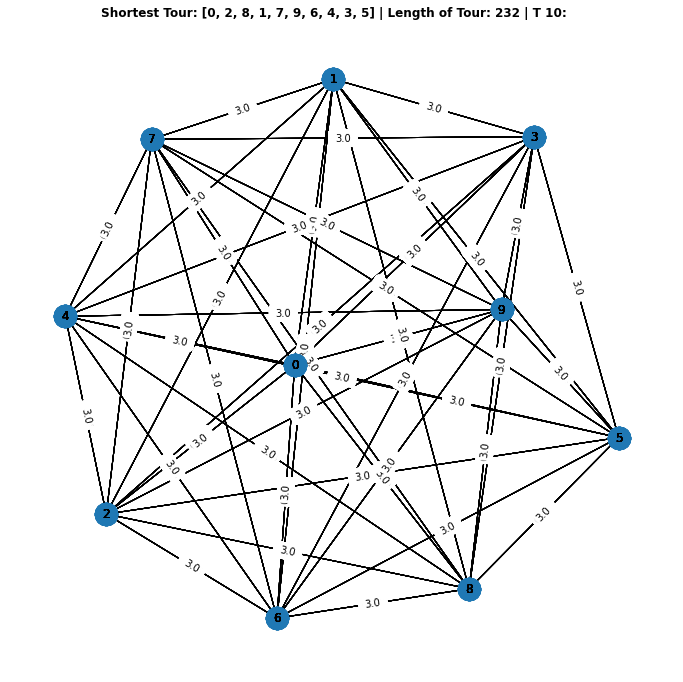

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation

T_PER_FRAME = 10

labels = {0: '0', 1: '1', 2:'2', 3: '3', 4:'4', 5: '5', 6:'6', 7: '7', 8: '8', 9: '9'}

fig, ax = plt.subplots(figsize=(12,12))
my_pos = nx.spring_layout(g, seed = 100)


def update(num):

  edge_labels = intensities[list(intensities.keys())[num * T_PER_FRAME]]

  for key in edge_labels.keys():
    edge_labels[key] = float("%.2f" % float(edge_labels[key]))

  ax.clear
  nx.draw(g, pos=my_pos, node_size=500, labels=labels, with_labels=True, ax=ax)
  nx.draw_networkx_edge_labels(g, pos=my_pos, edge_labels=edge_labels, ax=ax)

  ax.set_title("Shortest Tour: " + str(shortest_tour) + " | Length of Tour: " + str(shortest_tour_len) + " | T %d:    "%((num+1)*T_PER_FRAME), fontweight="bold")
  ax.set_xticks([])
  ax.set_yticks([])

ani = animation.FuncAnimation(fig, update, frames=10, interval=1000, repeat=True)

from IPython.display import HTML
HTML(ani.to_html5_video())

Below is code to visualize on the shortest path found on the graph. All edges except those in the shortest path found are removed. We use this to generate static images and also visualize and animate the edge intensities for just the shortest path found later on

In [ ]:
# Visualize shortest path
def viz_shortest_tour(g, tour):
  tour_edges = list(zip(tour, tour[1:]))
  print(tour_edges)
  labels = {0: '0', 1: '1', 2:'2', 3: '3', 4:'4', 5: '5', 6:'6', 7: '7', 8: '8', 9: '9'}

  new_graph = g.copy()

  for edge in new_graph.edges():
    if edge not in tour_edges and (edge[1], edge[0]) not in tour_edges:
      new_graph.remove_edge(*edge)

  my_pos = nx.spring_layout(g, seed = 100)


  print(new_graph.edges())
  nx.draw(new_graph, pos=my_pos, node_size=500, labels=labels, with_labels=True)

  return new_graph




##Parameter Testing

The main parameters that we tested changing are the number of ants, as well as the ALPHA and BETA parameters. We did no statistical testing to determine significant changes, so it is unsure how accurate these results really are.

In [ ]:
intensities, shortest_tour, shortest_tour_len = ant_cycle_algo(g, 10, 0, visibility, ALPHA=10, BETA=10)

[0, 5, 2, 4, 7, 8, 1, 9, 3, 6]
205


[(0, 5), (5, 2), (2, 4), (4, 7), (7, 8), (8, 1), (1, 9), (9, 3), (3, 6)]
[(0, 5), (1, 8), (1, 9), (2, 4), (2, 5), (3, 6), (3, 9), (4, 7), (7, 8)]


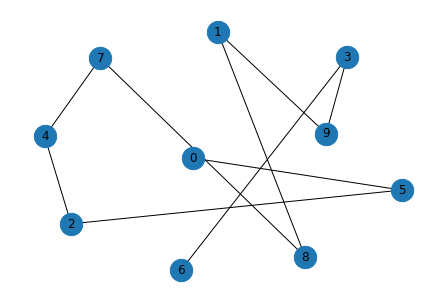

In [ ]:
viz_shortest_tour(g, [0, 5, 2, 4, 7, 8, 1, 9, 3, 6])

Below is testing 20 ants vs 10. A shorter path was found in 10,000 cycles

In [ ]:
intensities, shortest_tour, shortest_tour_len = ant_cycle_algo(g, 20, 0, visibility, ALPHA=10, BETA=10)

[0, 7, 8, 5, 6, 9, 1, 2, 4, 3]
186


[(0, 7), (7, 8), (8, 5), (5, 6), (6, 9), (9, 1), (1, 2), (2, 4), (4, 3)]
[(0, 7), (1, 2), (1, 9), (2, 4), (3, 4), (5, 6), (5, 8), (6, 9), (7, 8)]


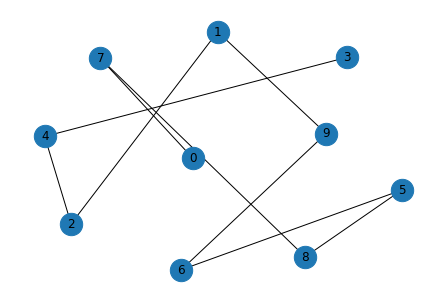

In [ ]:
viz_shortest_tour(g, shortest_tour)

The code below tests 50 ants. A shorter path was found than with 10 ants, but its a longer path than 20. It is unclear whether this is actually due to the number of ants or different decision making. It might make sense that too many ants would make results worse since there are more ants to randomly take less efficient paths and lay down trail intensity.

In [ ]:
intensities, shortest_tour, shortest_tour_len = ant_cycle_algo(g, 50, 0, visibility, ALPHA=10, BETA=10)

[0, 8, 2, 4, 6, 3, 9, 1, 7, 5]
192


[(0, 8), (8, 2), (2, 4), (4, 6), (6, 3), (3, 9), (9, 1), (1, 7), (7, 5)]
[(0, 8), (1, 7), (1, 9), (2, 4), (2, 8), (3, 6), (3, 9), (4, 6), (5, 7)]


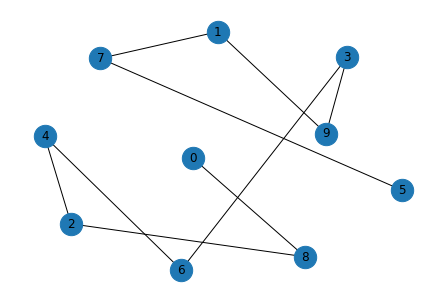

In [ ]:
viz_shortest_tour(g, shortest_tour)

Below is code for testing a higher alpha. This change found a longer path than the initial tests.

In [ ]:
intensities, shortest_tour, shortest_tour_len = ant_cycle_algo(g, 10, 0, visibility, ALPHA=100, BETA=10)

[0, 9, 6, 3, 8, 1, 7, 2, 5, 4]
225


The two snippets below test a higher beta value. Both are lower than the initial test but it is unclear whether this is because of the larger beta value or because of the random decisions being made by ants.

In [ ]:
intensities, shortest_tour, shortest_tour_len = ant_cycle_algo(g, 10, 0, visibility, ALPHA=10, BETA=100)

[0, 6, 3, 4, 7, 8, 5, 2, 9, 1]
185


In [ ]:
intensities, shortest_tour, shortest_tour_len = ant_cycle_algo(g, 10, 0, visibility, ALPHA=10, BETA=100)

[0, 8, 7, 4, 2, 1, 9, 3, 6, 5]
200


[(0, 8), (8, 7), (7, 4), (4, 2), (2, 1), (1, 9), (9, 3), (3, 6), (6, 5)]
[(0, 8), (1, 2), (1, 9), (2, 4), (3, 6), (3, 9), (4, 7), (5, 6), (7, 8)]


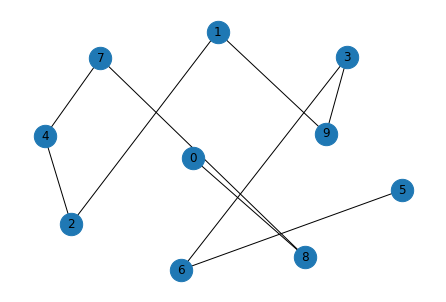

In [ ]:
new_g = viz_shortest_tour(g, shortest_tour)

The code below generates an animation for the higher beta test that shows the change in edge intensity on only the ultimate shortest path. The animation covers the first 1,000 cycles of the optimization process.

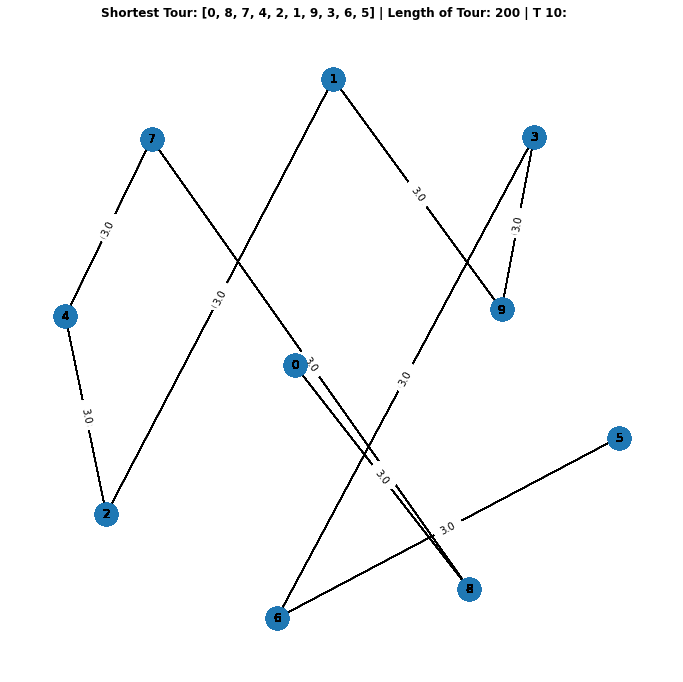

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation

T_PER_FRAME = 10

labels = {0: '0', 1: '1', 2:'2', 3: '3', 4:'4', 5: '5', 6:'6', 7: '7', 8: '8', 9: '9'}

fig, ax = plt.subplots(figsize=(12,12))
my_pos = nx.spring_layout(g, seed = 100)


def update(num):

  edge_labels = intensities[list(intensities.keys())[num * T_PER_FRAME]]
  new_edge_labels = {}
  for edge in edge_labels.keys():
    if edge in new_g.edges():
      new_edge_labels[edge] = edge_labels[edge]

  for key in edge_labels.keys():
    edge_labels[key] = float("%.2f" % float(edge_labels[key]))

  ax.clear
  nx.draw(new_g, pos=my_pos, node_size=500, labels=labels, with_labels=True, ax=ax)
  nx.draw_networkx_edge_labels(new_g, pos=my_pos, edge_labels=new_edge_labels, ax=ax)

  ax.set_title("Shortest Tour: " + str(shortest_tour) + " | Length of Tour: " + str(shortest_tour_len) + " | T %d:    "%((num+1)*T_PER_FRAME), fontweight="bold")
  ax.set_xticks([])
  ax.set_yticks([])

ani = animation.FuncAnimation(fig, update, frames=100, interval=1000, repeat=True)

from IPython.display import HTML
HTML(ani.to_html5_video())

# Potential Extensions

If we were to put more work into this project the following would be the best areas to do so:

1. Testing different trail laying functions. The equation we settled on for this process involved ants laying down trail after completing an entire tour. Other potential solutions include the ant-density algorithm which would have the ant lay down a specified amount of trail every time it crossed an edge as well as the ant-quantity algorithm which would have the ant lay down an amount of trail that is inversely proportional to the visibility every time it crossed an edge.

2. Another addition that could be made to our algorithm is the rule that once an edge drops below a specified trail intensity, that edge is removed from the graph all together. This would ensure that time and energy is not wasted on negligible edges in the graph.

3. Another extension would be to attempt to abstract the algorithm over multiple types of problems. For example: we had two main problems that we applied it towards - shortest path and TSP. It may be possible to create a single version of the code that could be applied more easily towards both problems with significantly less duplication.

4. As an extension to #3 there is the consideration of additional problems. Graphs are a very broad subject which has numerous other problems found within it. For example it can be applied towards classication as shown in this paper https://ieeexplore.ieee.org/abstract/document/4336122.

5. One other area of potential exploration and expansion would be in a more formal aspect. It could be useful to analyze the time complexity of our implementations as well as their relative probabilities towards obtaining the optimal (or an optimal) solution.

# Works Cited

M. Dorigo, V. Maniezzo, et A. Colorni, Ant system: optimization by a colony of cooperating agents, IEEE Transactions on Systems, Man, and Cybernetics--Part B , volume 26, numéro 1, pages 29-41, 1996.

http://www.cs.unibo.it/babaoglu/courses/cas05-06/tutorials/Ant_Colony_Optimization.pdf